In [61]:
from pathlib import Path
import tifffile
import miguel_tools as mt
import iTools as iT
import datetime
from skimage import filters
import napari
import pandas as pd
from collections import defaultdict
import math
from scipy.spatial import distance
from matplotlib import pyplot as plt
import numpy as np
from tkinter import filedialog
from tkinter import *
import pandas as pd
from skimage import morphology, filters, measure, feature, registration
# import warnings
# warnings.filterwarnings('ignore')

In [62]:
# %gui qt

# from PyQt5.QtWidgets import QFileDialog

# def gui_fname(dir=None):
#     """Select a file via a dialog and return the file name."""
#     if dir is None: dir ='./'
#     fname = QFileDialog.getOpenFileName(None, "Select data file...", 
#                 dir, filter="All files (*);; SM Files (*.sm)")
#     return fname[0]

# def gui_dir(dir=None):
#     """Select a directory path via a dialog and return the path."""
#     if dir is None: dir ='./'
#     dir_name = QFileDialog.getExistingDirectory(None, 'Select a folder:', 'C:\\', QFileDialog.ShowDirsOnly)
#     return dir_name

In [63]:
def ask_folder():
    root = Tk()
    root.withdraw()
    folder_selected = filedialog.askdirectory()
    folder_selected = Path(folder_selected)
    return folder_selected

def ask_file():
    root = Tk()
    root.withdraw()
    file_selected = filedialog.askopenfilename()
    file_selected = Path(file_selected)
    return file_selected

def calculate_shift_with_marker(im, slide):
    with napari.gui_qt():
        viewer = napari.Viewer()
        viewer.add_image(im[slide-2:slide+2])
        viewer.add_points(name='point1', face_color='red', opacity=0.9, symbol='square', size=1, n_dimensional=False)
#         viewer.add_points(name='point2', face_color='green', opacity=0.9, symbol='disc', size=1, n_dimensional=False)

    p1, p2 = viewer.layers['point1'].__dict__['_data'][:,1:]
    p1y, p1x = p1[0], p1[1]
    p2y, p2x = p2[0], p2[1]

    manual_shift = [int(round(i)) for i in [p2y - p1y, p2x - p1x]]
    return manual_shift

def calculate_shift(im1, im2):
    shift, error, diffphase = registration.phase_cross_correlation(im1, im2)
#     print(shift, error, diffphase)
    return [int(i) for i in shift]

def shiftIM(im, shift):
    Xshifted = np.roll(im, shift=shift[1], axis=1)
    Yshifted = np.roll(Xshifted, shift=shift[0], axis=0)
    return Yshifted

def registration_checkpoint(im1, im2, shift, savein=None):
    fig, ax = plt.subplots(ncols=2, figsize=(20,10))
    ax[0].set_title("Raw")
    ax[0].imshow(im1, alpha=0.5, cmap='Reds')
    ax[0].imshow(im2, alpha=0.5, cmap='Greens')
    
    im2_shifted = shiftIM(im2, shift)
    ax[1].set_title("Shifted")
    ax[1].imshow(im1, alpha=0.5, cmap='Reds')
    ax[1].imshow(im2_shifted, alpha=0.5, cmap='Greens')
    
    for i in ax:
        i.axis('off')
    
    if savein != None:
        plt.savefig(savein, dpi=300, bbox_inches = 'tight')

def alignment(im, rot):   
    with napari.gui_qt():
        viewer = napari.Viewer()
        viewer.add_image(im[rot-1], opacity=1, colormap='red')
        viewer.add_image(im[rot], opacity=0.5, colormap='yellow')
    #     region = viewer.add_shapes(name='region', shape_type='rectangle', 
    #                                edge_width=5, edge_color='black', face_color='royalblue',
    #                                ndim=seedling_im[rot].ndim)
        points = viewer.add_points(name='subregion', face_color='red', opacity=0.9, symbol='disc', size=25)
        points.mode = 'add'

    # region.to_labels().shape 
    # For some reason this doesn't work 
    # properly still so I will try next time running this with the other environtment where napari is 0.4.4

    coordinates = points.data
    coordinates = coordinates.astype(int)

    y1, x1, y2, x2 = coordinates.ravel()
    reg1, reg2 = im[rot-1][y1:y2, x1:x2], im[rot][y1:y2, x1:x2]
    shift = calculate_shift(reg1, reg2)

    first_part = im[:rot]
    second_part = []

    for sl in range(rot, im.shape[0]):
        second_part.append(shiftIM(im[sl], shift))
    second_part = np.stack(second_part, axis=0)
    im_aligned = np.concatenate([first_part, second_part], axis=0)

    return im_aligned

In [64]:
print("Choose the seedling to record the points to track\n")

seedling_tifpath = ask_file()
# seedling_tifpath = Path(gui_fname())
# seedling_tifpath = Path(r'D:/TEMP_PICTURES/Lichun/Lichun_Plate1_Full_results/Lichun_Plate1_Full_seedling_1.tif')

Choose the seedling to record the points to track



In [65]:
seedling_name = seedling_tifpath.stem

In [66]:
seedling_im = tifffile.imread(seedling_tifpath)

In [67]:
imageDescription = mt.extract_metadata_TiFF(seedling_tifpath, short=False)['ImageDescription'][0].split("\n")
metadata = {}
for i in imageDescription:
    try:
        metadata[i.split("=")[0]] = i.split("=")[1]
    except:
        pass

In [68]:
rot = int(metadata['slide_rotated'])

timepoints = sorted(metadata['timepoints'].replace("[", "").replace(" ", "").replace("]", "").replace("'", "").replace("'", "").split(","))
timepoints = [datetime.datetime.strptime(i, "%Y%m%d_%H%M%S") for i in timepoints]

pixel_size = float(metadata['pixel_size_mm'])

In [70]:
seedling_im = alignment(seedling_im, rot)

In [ ]:
# Resaving the image aligned
tifffile.imsave(file=seedling_tifpath, 
                    data=np.uint8(seedling_im), 
                    imagej=True,
                   metadata=metadata)

# Highlighting and rotating

In [12]:
print("Rotating and highlighting the seedling\n")
plant_highlithed = filters.sobel(seedling_im)
plant_highlithed_rot = np.rot90(plant_highlithed, axes=(1,2))
# plant_highlithed_rot = seedling_im

# Extracting points

In [13]:
with napari.gui_qt():
    viewer = napari.Viewer()
    viewer.add_image(plant_highlithed_rot)
    viewer.add_points(name='path', face_color='red', opacity=0.9, symbol='square', size=1, ndim=plant_highlithed_rot.ndim)
    viewer.layers['path'].mode = 'add'

In [14]:
DATA = pd.DataFrame(viewer.layers['path'].__dict__['_data'], columns=['point', 'y', 'x'])

DATA.insert(loc=0, column='cap', value=DATA.index)
DATA.insert(loc=0, column='time', value=pd.Series(timepoints))
DATA.insert(loc=0, column='seedling_name', value=seedling_name)
DATA['x_mm'] = DATA.x.apply(lambda x: x*pixel_size)
DATA['y_mm'] = DATA.y.apply(lambda y: y*pixel_size)

In [15]:
DATA

,seedling_name,time,cap,point,y,x,x_mm,y_mm
0,2020-12-18_plate1_seedling_1,2020-12-18 13:49:28,0,0.0,176.334715,504.471421,18.277950,6.388939
1,2020-12-18_plate1_seedling_1,2020-12-18 14:09:28,1,1.0,176.467896,506.202773,18.340680,6.393764
2,2020-12-18_plate1_seedling_1,2020-12-18 14:29:28,2,2.0,173.937458,509.265935,18.451664,6.302082
3,2020-12-18_plate1_seedling_1,2020-12-18 14:49:28,3,3.0,174.869724,509.399116,18.456490,6.335860
4,2020-12-18_plate1_seedling_1,2020-12-18 15:09:29,4,4.0,175.535629,511.796373,18.543347,6.359987
...,...,...,...,...,...,...,...,...
502,2020-12-18_plate1_seedling_1,2020-12-25 13:09:28,502,502.0,516.345660,851.807326,30.862584,18.708176
503,2020-12-18_plate1_seedling_1,2020-12-25 13:29:28,503,503.0,517.810650,851.674145,30.857759,18.761255
504,2020-12-18_plate1_seedling_1,2020-12-25 13:49:29,504,504.0,519.408822,851.008241,30.833632,18.819160
505,2020-12-18_plate1_seedling_1,2020-12-25 14:09:28,505,505.0,520.474269,851.407783,30.848108,18.857763


In [16]:
angle_of_line = lambda point1, point2: math.degrees(math.atan2(point2['y']-point1['y'], \
                                                               point2['x']-point1['x'])) 

middle_point = lambda point1, point2: ((point1['y']+(point2['y'] - point1['y'])/2), \
                                            (point1['x']+(point2['x'] - point1['x'])/2))

eu = lambda point1, point2: distance.euclidean((point1['y_mm'],point1['x_mm']), 
                                               (point2['y_mm'],point2['x_mm']))

In [17]:
middles = defaultdict(list)
for i in DATA.index:
    try:
        middle = middle_point(DATA.loc[i], DATA.loc[i+1])
        middles['caps'].append("{}-{}".format(int(DATA.loc[i]['cap']), int(DATA.loc[i+1]['cap'])))
        middles['y_degrees_label'].append(middle[0])
        middles['x_degrees_label'].append(middle[1])

            
        time_dif = (DATA.loc[i+1]['time'] - DATA.loc[i]['time']).total_seconds()
        degree = angle_of_line(DATA.loc[i], DATA.loc[i+1])
        euclidean = eu(DATA.loc[i], DATA.loc[i+1])            
        middles['degree'].append(degree)
        middles['euclidean (mm)'].append(euclidean)
        middles['time_dif (s)'].append(time_dif)
        middles['speed (mm/s)'].append(euclidean/time_dif)
    except:
        pass

DFresults = pd.DataFrame(middles)
DFresults['speed (mm/h)'] = DFresults['speed (mm/s)'].apply(lambda x: x*60*60)

In [18]:
DFresults

,caps,y_degrees_label,x_degrees_label,degree,euclidean (mm),time_dif (s),speed (mm/s),speed (mm/h)
0,0-1,176.401305,505.337097,4.398705,0.062915,1200.0,0.000052,0.188746
1,1-2,175.202677,507.734354,-39.559668,0.143955,1200.0,0.000120,0.431866
2,2-3,174.403591,509.332526,81.869898,0.034121,1200.0,0.000028,0.102362
3,3-4,175.202677,510.597745,15.524111,0.090146,1201.0,0.000075,0.270212
4,4-5,175.602220,512.062735,14.036243,0.019896,1200.0,0.000017,0.059687
...,...,...,...,...,...,...,...,...
501,501-502,515.812936,851.940507,104.036243,0.039791,1199.0,0.000033,0.119473
502,502-503,517.078155,851.740736,95.194429,0.053298,1200.0,0.000044,0.159895
503,503-504,518.609736,851.341193,112.619865,0.062730,1201.0,0.000052,0.188034
504,504-505,519.941545,851.208012,69.443955,0.041228,1199.0,0.000034,0.123788


In [ ]:
print("Saving {}".format(seedling_tifpath.parent / "{}.xlsx".format(seedling_name)))

In [19]:
mt.writting_excel(DF=[DATA, DFresults], 
              pathname=seedling_tifpath.parent / "{}.xlsx".format(seedling_name), 
              sheet_name=['raw_data', 'degrees'])

In [13]:
def degrees_plot(DATA, DFresults, seedling_name):

    ## Degrees plot
    fig, ax = plt.subplots(figsize=(15,5))
    # drift = 0
    # last_position = 0
    # plt.imshow(plant_highlithed_rot[-1])
    for name, group in DATA.groupby(['cap']):
        plt.scatter(group.x, group.y, label=timepoints[int(name)])

    plt.plot(DATA.x, DATA.y, color='grey', linestyle='--')
    degreeDF = DFresults
    for ix, dg in enumerate(degreeDF['degree']):
        plt.text(x=degreeDF.loc[ix]['x_degrees_label']-2,y=degreeDF.loc[ix]['y_degrees_label']+2, 
                 s="{}$^\circ$".format(math.ceil(dg)), size=12)

    plt.ylabel(" distance (mm)")
    plt.xlabel(" distance (mm)")
    plt.ylim(DATA.y.max()+10, DATA.y.min()-10) 


    xlocs, xlabels = plt.xticks()
    xnewlabels = [round(i * pixel_size) for i in xlocs]
    plt.xticks(ticks=xlocs, labels=xnewlabels, rotation=0);

    ylocs, ylabels = plt.yticks()
    ynewlabels = [round(i * pixel_size) for i in ylocs]
    plt.yticks(ticks=ylocs, labels=ynewlabels, rotation=0);

    handles, labels = ax.get_legend_handles_labels()
    ax.legend([list(handles)[0], list(handles)[-1]], 
              [list(labels)[0],list(labels)[-1]],
              loc="upper left",bbox_to_anchor=(1.04,1))

    plt.title("{}".format(seedling_name))
    plt.grid(axis='both')

#     ax.legend();
    
    plt.savefig(seedling_tifpath.parent / "{}_lateral_view_degrees.png".format(seedling_name), dpi=300, bbox_inches = 'tight')
    plt.savefig(seedling_tifpath.parent / "{}_lateral_view_degrees.svg".format(seedling_name), dpi=300, bbox_inches = 'tight')
    plt.show()

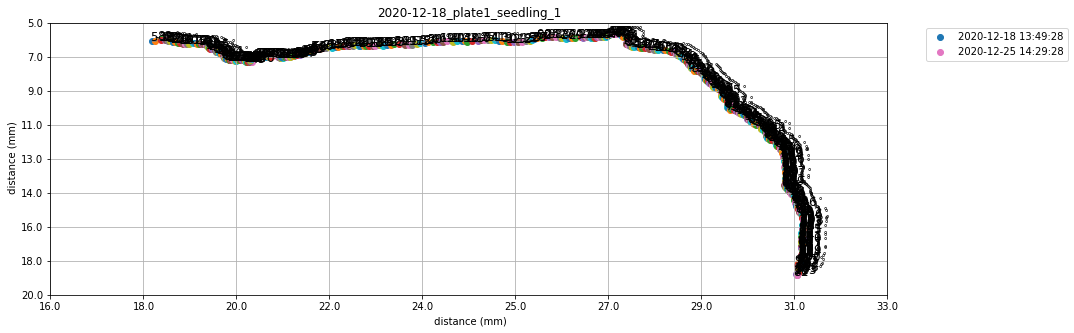

In [21]:
degrees_plot(DATA, DFresults, seedling_name)